#### Tournament

every so often a tournament is held batch updating the rankings then readjusting the portfolio according to those rankings.

In [514]:
import numpy as np
import matplotlib.pyplot as plt

from src.eval import Evaluation
from src.rating import Elo_Player, Glicko2_Player
from src.generator import BrownianMotion
from src.tools import generate_returns

In [515]:
# generate data

t, dat_ = BrownianMotion().generator(n_=6, T=100, dt=1, r_walk=[0.0001, 0.05, 20],
                                     hyper_mu=[0.00000, 0.0001, 0],
                                     hyper_sigma=[0.000, 0.01, 0.06])

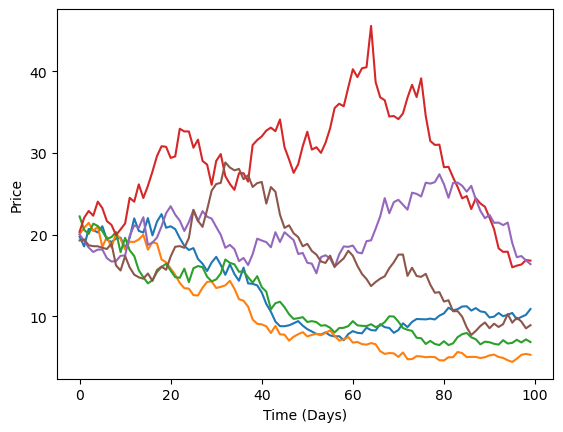

In [516]:
for i in dat_:
    plt.plot(i)

plt.ylabel('Price')
plt.xlabel('Time (Days)')
plt.show()

In [517]:
# generate returns
returns = generate_returns(arr=dat_)

In [518]:
# Calculate the average return across assets for each time period
portfolio_returns = np.mean(returns, axis=0)

# Calculate the cumulative returns
cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

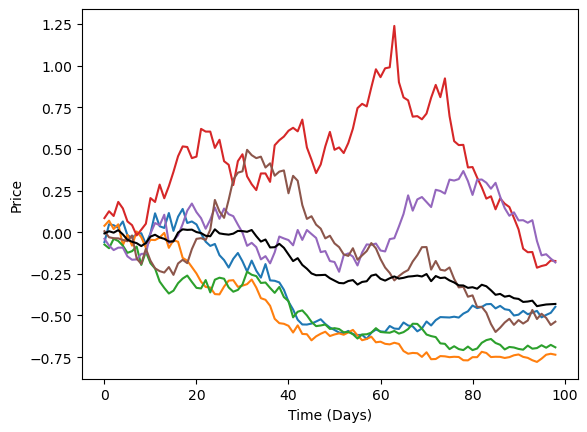

In [519]:
for i in range(0, returns.shape[0]):
    plt.plot(np.cumprod(1 + returns[i]) - 1)

plt.plot(cumulative_returns, color='black')
plt.ylabel('Price')
plt.xlabel('Time (Days)')
plt.show()

In [520]:
returns = returns.T
returns.shape


(99, 6)

In [521]:
returns

array([[-6.01380114e-02,  3.85898969e-02, -7.40887724e-02,
         8.45841689e-02, -3.96932449e-02,  6.07214081e-03],
       [ 1.14728363e-01,  2.95285213e-02, -2.40958011e-02,
         3.78126019e-02, -4.21522475e-02, -3.63628669e-02],
       [-5.57071536e-03, -4.71828220e-02,  6.23618102e-02,
        -2.51657625e-02, -2.96207137e-02, -5.88255618e-03],
       [-1.53334002e-02,  2.79296207e-02, -1.31319442e-02,
         7.69884042e-02,  1.62795641e-02, -8.93064212e-04],
       [ 3.74962880e-02, -1.19243965e-01, -2.97046652e-02,
        -3.30305274e-02,  3.53365369e-04, -9.79941546e-03],
       [-7.80564165e-02,  6.66244312e-02, -4.68332392e-02,
        -6.82696829e-02, -5.82063688e-02, -8.11772312e-03],
       [-1.45744286e-02, -6.57115112e-02,  1.13141550e-02,
        -2.12923147e-02, -2.34782404e-02,  3.64539608e-02],
       [ 2.15566949e-02,  9.25511243e-02,  3.11123907e-02,
        -5.88312038e-02,  2.27781025e-03, -1.41432461e-01],
       [ 6.31262177e-03, -3.38971283e-02, -1.206

In [522]:
# pairwise comparisons to get win/loss array

# Create the win_loss_arr with the correct shape (time, assets, assets)
win_loss_arr = np.zeros((returns.shape[0], returns.shape[1], returns.shape[1]))

# Initialize ratings array with the first time step ratings set to 1500
ratings = np.zeros((returns.shape[0], returns.shape[1]))
ratings[0] = 1500

# Initialize Elo_Player instances for each asset
players = [Elo_Player(rating=1500) for _ in range(returns.shape[1])]


for t in range(returns.shape[0]):
    # daily tournament
    for i in range(returns.shape[1]):
        for j in range(returns.shape[1]):
            if i == j:
                win_loss_arr[t, i, j] = np.nan
            else:
                win_loss_arr[t, i, j] = Evaluation.above_below_equal(s1=returns[t, i], s2=returns[t, j])


    # Update ratings using online_update
    for i in range(returns.shape[1]):
        outcomes = []
        opponent_ratings = []
        for j in range(returns.shape[1]):
            if i != j:
                outcomes.append(win_loss_arr[t, i, j])
                opponent_ratings.append(players[j].get_rating())

        players[i].online_update(outcomes=outcomes, ratings=opponent_ratings)
        ratings[t,i] = players[i].get_rating()


print("Shape of win_loss_arr:", win_loss_arr.shape)
print("win_loss_arr example slice for time t=0:\n", win_loss_arr[0])

Shape of win_loss_arr: (99, 6, 6)
win_loss_arr example slice for time t=0:
 [[nan  0.  1.  0.  0.  0.]
 [ 1. nan  1.  0.  1.  1.]
 [ 0.  0. nan  0.  0.  0.]
 [ 1.  1.  1. nan  1.  1.]
 [ 1.  0.  1.  0. nan  0.]
 [ 1.  0.  1.  0.  1. nan]]


In [523]:
players[0].get_rating()

1629.4620898417672

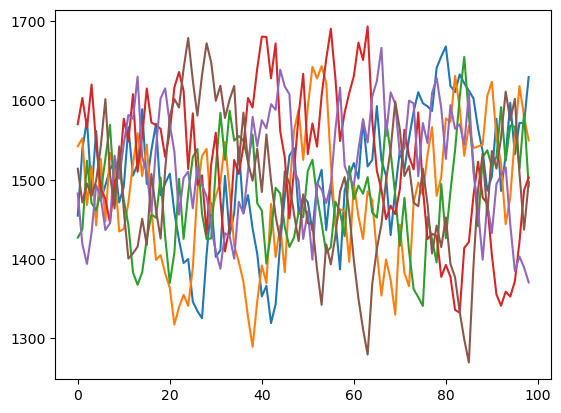

In [524]:
# get elo ratings
for i in range(0, ratings.shape[1]):
    plt.plot(ratings[:,i])
plt.show()

In [525]:
# Assuming Elo_Player and Evaluation classes are already defined and the code to update ratings is executed

def rank_players_over_time(ratings):
    """
    Rank players from best to worst over time.

    Parameters:
    ratings (np.ndarray): Array of player ratings with shape (time, players)

    Returns:
    np.ndarray: Array of player rankings with shape (time, players), where each row contains the ranked indices of players
    """
    rankings = np.zeros_like(ratings, dtype=int)

    for t in range(ratings.shape[0]):
        rankings[t] = np.argsort(-ratings[t])

    return rankings

In [526]:
# rank players
rankings = rank_players_over_time(ratings)

print("Rankings example for time t=0:\n", rankings[0])


Rankings example for time t=0:
 [3 1 5 4 0 2]


In [527]:
def calculate_long_short_returns(rankings, returns, long_pct=0.2, short_pct=0.2, invert=False):
    """
    Calculate the portfolio returns by shorting the bottom X% and going long on the top Y% of players.

    Parameters:
    returns (np.ndarray): Array of player returns with shape (time, players)
    long_pct (float): Percentage of players to go long on (top Y%)
    short_pct (float): Percentage of players to short (bottom X%)

    Returns:
    np.ndarray: Array of cumulative portfolio returns over time
    """

    n_players = returns.shape[1]

    long_count = int(n_players * long_pct)
    short_count = int(n_players * short_pct)

    portfolio_returns = np.zeros(returns.shape[0] - 1)  # One less because of the offset

    for t in range(returns.shape[0] - 1):  # Adjust the loop to avoid index out of range
        if invert is False:
            top_indices = rankings[t, :long_count]
            bottom_indices = rankings[t, -short_count:]
        else:
            top_indices = rankings[t, -short_count:]
            bottom_indices = rankings[t, :long_count]

        long_returns = np.mean(returns[t + 1, top_indices])
        short_returns = np.mean(returns[t + 1, bottom_indices])

        # Portfolio return: long returns minus short returns
        portfolio_returns[t] = long_returns - short_returns

    cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

    return cumulative_returns

In [528]:
cumulative_returns_strat = calculate_long_short_returns(rankings, returns, long_pct=0.2, short_pct=0.2, invert=False)

cumulative_returns_strat_invert = calculate_long_short_returns(rankings, returns, long_pct=0.2, short_pct=0.2, invert=True)


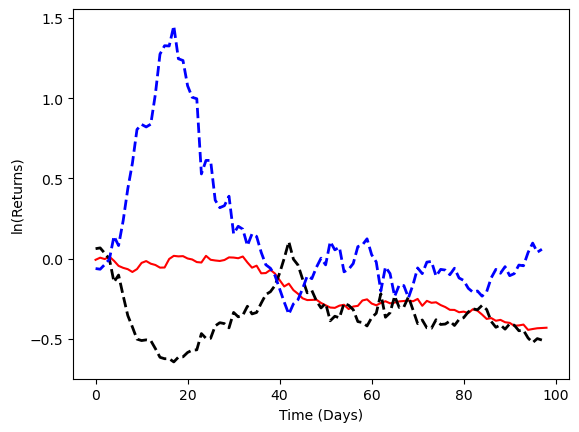

In [529]:
plt.plot(cumulative_returns, color='red')
plt.plot(cumulative_returns_strat, color='black', linestyle='--', linewidth=2)
plt.plot(cumulative_returns_strat_invert, color='blue', linestyle='--', linewidth=2)
plt.ylabel('ln(Returns)')
plt.xlabel('Time (Days)')
plt.show()

In [530]:
# pairwise comparisons to get win/loss array

# Create the win_loss_arr with the correct shape (time, assets, assets)
win_loss_arr = np.zeros((returns.shape[0], returns.shape[1], returns.shape[1]))

# Initialize ratings array with the first time step ratings set to 1500
ratings = np.zeros((returns.shape[0], returns.shape[1]))
rds = np.zeros((returns.shape[0], returns.shape[1]))
ratings[0] = 1500
rds[0] = 350

# Initialize Elo_Player instances for each asset
players = [Glicko2_Player() for _ in range(returns.shape[1])]


for t in range(returns.shape[0]):
    # daily tournament
    for i in range(returns.shape[1]):
        for j in range(returns.shape[1]):
            if i == j:
                win_loss_arr[t, i, j] = np.nan
            else:
                win_loss_arr[t, i, j] = Evaluation.above_below_equal(s1=returns[t, i], s2=returns[t, j])


    # Update ratings using online_update
    for i in range(returns.shape[1]):
        outcomes = []
        opponent_ratings = []
        opponent_rds = []
        for j in range(returns.shape[1]):
            if i != j:
                outcomes.append(win_loss_arr[t, i, j])
                opponent_ratings.append(players[j].getRating())
                opponent_rds.append(players[j].getRd())

        players[i].update_player(outcome_list=outcomes,
                                 RD_list=opponent_rds,
                                 rating_list=opponent_ratings)
        ratings[t,i] = players[i].getRating()
        rds[t,i] = players[i].getRd()


print("Shape of win_loss_arr:", win_loss_arr.shape)
print("win_loss_arr example slice for time t=0:\n", win_loss_arr[0])

Shape of win_loss_arr: (99, 6, 6)
win_loss_arr example slice for time t=0:
 [[nan  0.  1.  0.  0.  0.]
 [ 1. nan  1.  0.  1.  1.]
 [ 0.  0. nan  0.  0.  0.]
 [ 1.  1.  1. nan  1.  1.]
 [ 1.  0.  1.  0. nan  0.]
 [ 1.  0.  1.  0.  1. nan]]


In [531]:
rankings = rank_players_over_time(ratings)

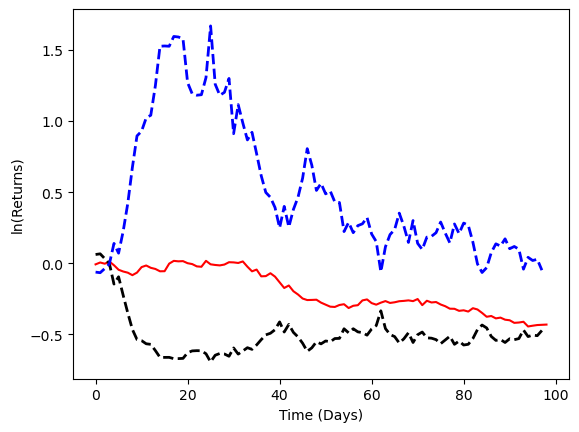

In [532]:
cumulative_returns_strat = calculate_long_short_returns(rankings, returns, long_pct=0.2, short_pct=0.2, invert=False)

cumulative_returns_strat_invert = calculate_long_short_returns(rankings, returns, long_pct=0.2, short_pct=0.2,
                                                               invert=True)

plt.plot(cumulative_returns, color='red')
plt.plot(cumulative_returns_strat, color='black', linestyle='--', linewidth=2)
plt.plot(cumulative_returns_strat_invert, color='blue', linestyle='--', linewidth=2)
plt.ylabel('ln(Returns)')
plt.xlabel('Time (Days)')
plt.show()